In [26]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize

import cv2

In [27]:

def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels


In [28]:
path_out = './Data/'
files = glob.glob(path_out+"*")
files.sort()


In [29]:
dx= 5.106500953873407 
dt= 0.0016


data = []
first_filename = files[0]
for file in files:
   data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)

Dataframe's vizualization provided by the teacher:

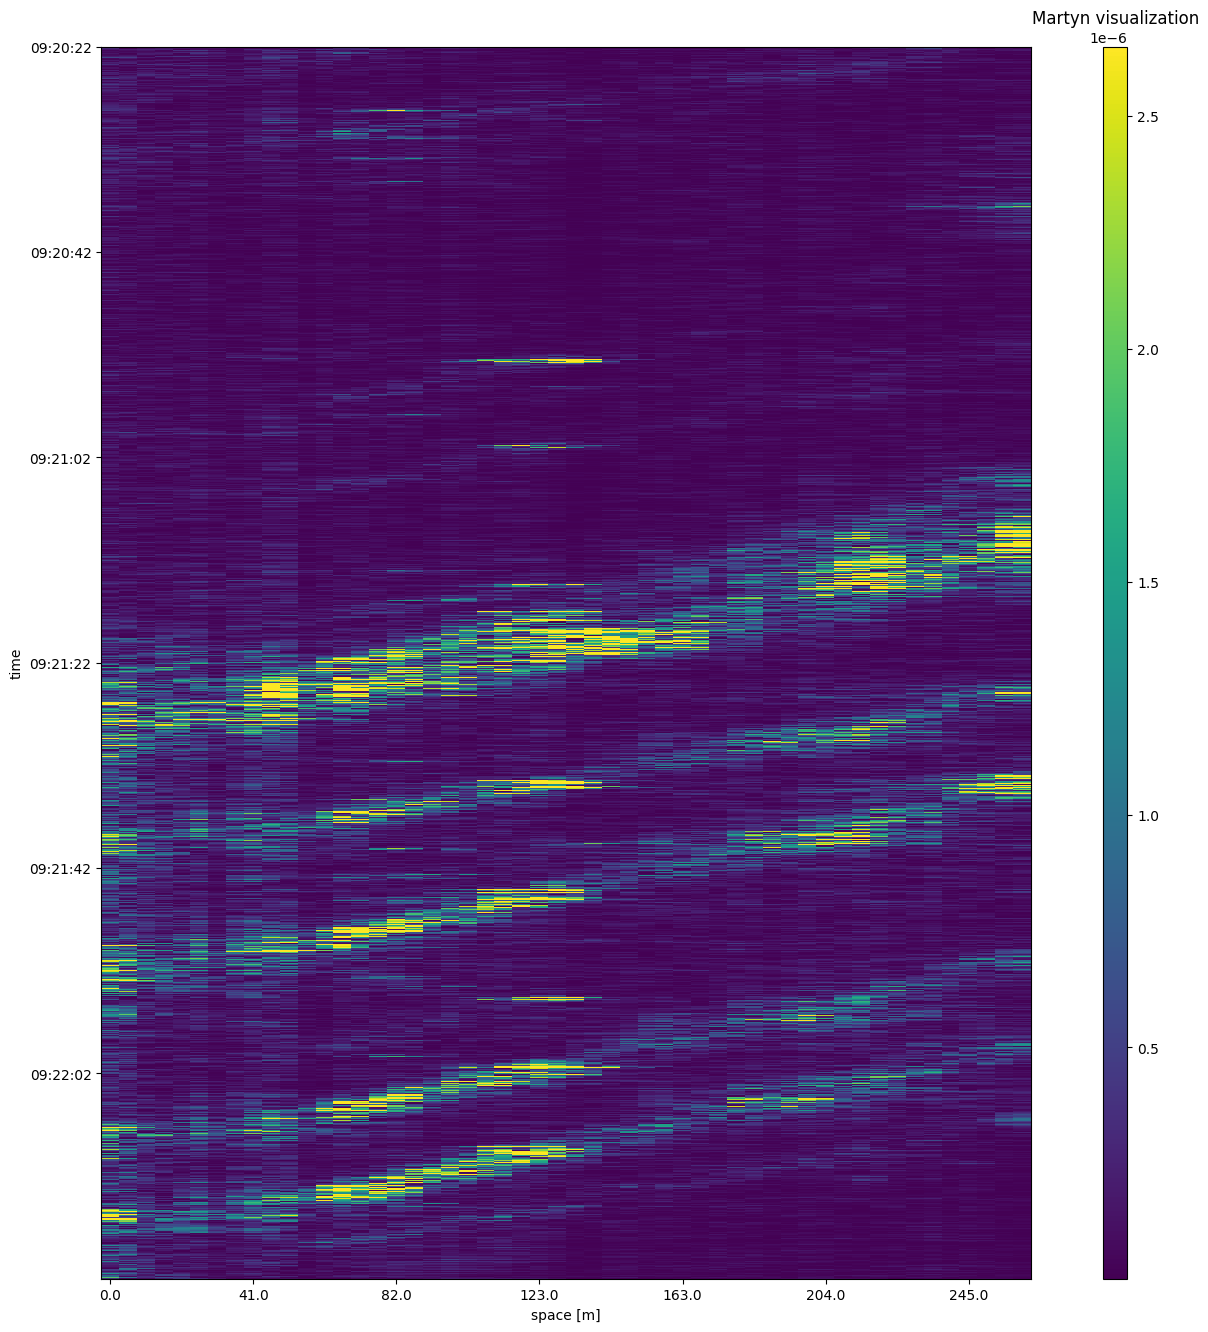

In [10]:


fig = plt.figure(figsize=(12,16))
ax = plt.axes()

# This is an example transformation and should be converted to the proper algorithm
df -= df.mean()
df = np.abs(df) 
low, high = np.percentile(df, [3, 99]) 
norm = Normalize(vmin=low, vmax=high, clip=True)

im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm)
plt.ylabel('time')
plt.xlabel('space [m]')

cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)
plt.title("Martyn visualization")
plt.show()

### Looking at how our dataframe looks like
Since we cannot see any information in here there is a need for the transformation; also we see that the size of it is quite large so we have decided to drop every second row of the dataframe


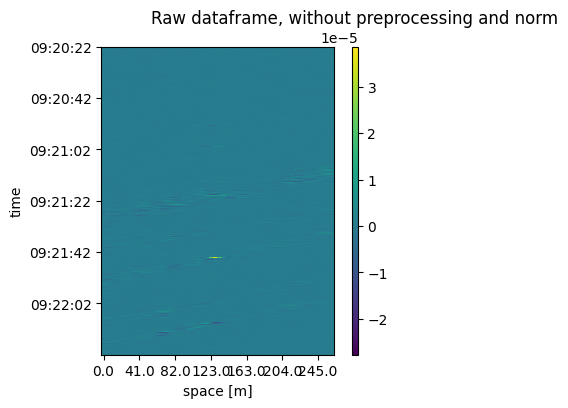

In [30]:
fig = plt.figure(figsize=(3,4))
ax = plt.axes()
im = ax.imshow(df,interpolation='none',aspect='auto')
plt.ylabel('time')
plt.xlabel('space [m]')

cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)
plt.title("Raw dataframe, without preprocessing and norm")
plt.show()

### Function for the vizualization of our dataframe


In [31]:
def visualize(dataframe, size_x = 3, size_y = 4):

    fig = plt.figure(figsize=(size_x, size_y))
    ax = plt.axes()

    im = ax.imshow(dataframe, interpolation='none', aspect='auto', norm=norm, cmap='viridis')
    plt.ylabel('time')
    plt.xlabel('space [m]')

    # Add colorbar
    cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)

    # Set axes labels
    x_positions, x_labels = set_axis(dataframe.columns)
    ax.set_xticks(x_positions, np.round(x_labels, 1))
    y_positions, y_labels = set_axis(dataframe.index.time)
    ax.set_yticks(y_positions, y_labels)

    plt.show()

### Our approach in basic preprocessing the data

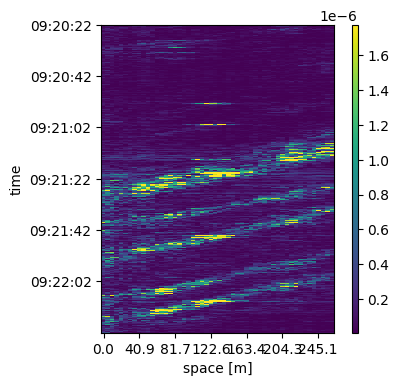

In [32]:
# Step 1: Remove mean and apply Fourier filtering
# Subtract the mean of each row (temporal mean subtraction) to center the data around zero.
# This step ensures that variations across time are more visible.
df = df.subtract(df.mean(axis=1), axis=0)

# Apply Fourier Transform to the data along the spatial dimension (columns).
# This transforms the data from the spatial domain into the frequency domain.
df_fft = np.fft.fft(df, axis=0)

# Remove low frequencies (which correspond to smoother, slower changes over space).
# This acts as a high-pass filter, removing smooth trends and keeping sharper, rapid variations.
# The `[:10]` selects the first 10 frequency components and sets them to 0.
df_fft[:10] = 0  

# Apply the inverse Fourier Transform to convert the data back to the spatial domain.
# Only the high-frequency components remain after this step.
# The `.real` extracts the real part of the complex values resulting from the inverse transform.
df_filtered = np.fft.ifft(df_fft, axis=0).real

# Reconstruct the DataFrame with the filtered data, preserving the original indexing and column labels.
df = pd.DataFrame(df_filtered, index=df.index, columns=df.columns)

# Step 2: Signal Magnitude Enhancement
# Compute the Root Mean Square (RMS) value for the data.
# This emphasizes the magnitude of changes and ensures all values are non-negative.
df = np.sqrt(df**2)

# Step 3: Edge Detection
# Use the Sobel filter from the `skimage.filters` library for edge detection.
# Sobel calculates the gradient of the data, which highlights transitions (edges) in the signal.
# This is particularly useful for identifying boundaries or rapid changes in the data.
from skimage.filters import sobel
df_edges = sobel(df.values)

# Convert the result back to a DataFrame for consistency with the original data structure.
df = pd.DataFrame(df_edges, index=df.index, columns=df.columns)

# Step 4: Normalize Data for Visualization
# Calculate the 3rd and 99th percentiles of the data to define a robust range for normalization.
# This prevents outliers from dominating the contrast in the visualization.
low, high = np.percentile(df, [3, 99])

# Create a normalization object to scale the data for visualization.
# The data will be clipped and scaled to the range [low, high].
from matplotlib.colors import Normalize
norm = Normalize(vmin=low, vmax=high, clip=True)

# The normalized data is now ready for visualization.


visualize(df)


From the shape we see that we migh get rid of every second row of the picture

In [12]:
df.shape

(75000, 52)

(37500, 52)


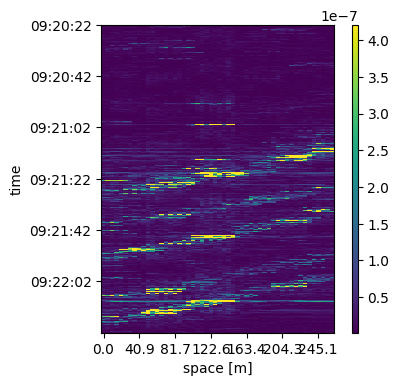

In [21]:
df_reduced = df.iloc[::2, :]
print(df_reduced.shape)

visualize(df_reduced)


In [ ]:
# Perform Fourier transform along the spatial dimension (columns)
df_fft = np.fft.fft(df_reduced, axis=1)

# Create a low-pass filter mask
num_cols = df_reduced.shape[1]
freq_cutoff = int(num_cols * 0.1)  # Retain 10% of low frequencies
low_pass_mask = np.zeros_like(df_fft)
low_pass_mask[:, :freq_cutoff] = 1  # Retain only the first few frequencies
low_pass_mask[:, -freq_cutoff:] = 1  # Symmetric frequencies

# Apply the low-pass filter
df_fft_filtered = df_fft * low_pass_mask

# Perform inverse Fourier transform to return to spatial domain
df_filtered = np.fft.ifft(df_fft_filtered, axis=1).real

# Convert back to DataFrame
df_filtered = pd.DataFrame(df_filtered, index=df_reduced.index, columns=df_reduced.columns)


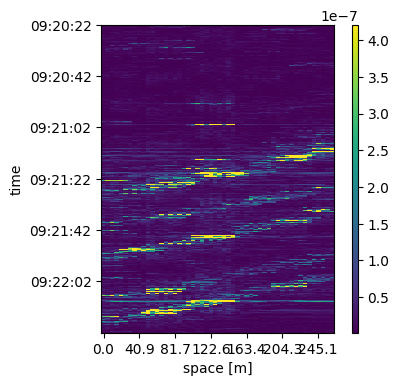

In [25]:
visualize(df_filtered)

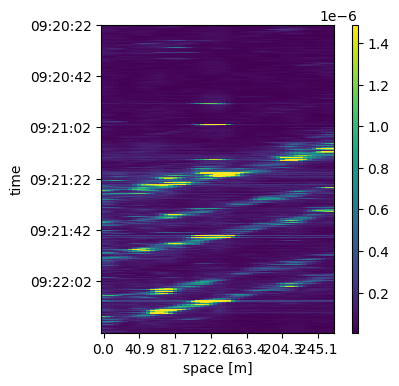

In [73]:
import cv2
import numpy as np

# Apply Gaussian blur
df_blurred = cv2.GaussianBlur(df.values, (5, 5), 0)  # (5, 5) is the kernel size; adjust as needed
df = pd.DataFrame(df_blurred, index=df.index, columns=df.columns)

# Re-visualize after Gaussian blur
fig = plt.figure(figsize=(3, 4))
ax = plt.axes()

im = ax.imshow(df, interpolation='none', aspect='auto', norm=norm, cmap='viridis')
plt.ylabel('time')
plt.xlabel('space [m]')

# Add colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)

x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)

plt.show()


## Binary tresholding
Threshold the smoothed data to create a binary mask for detecting significant signal regions.

In [74]:
df

,0.000000,5.106501,10.213002,15.319503,20.426004,25.532505,30.639006,35.745507,40.852008,45.958509,...,214.473040,219.579541,224.686042,229.792543,234.899044,240.005545,245.112046,250.218547,255.325048,260.431549
2024-05-07 09:20:22.000000,8.479635e-08,8.033761e-08,6.584595e-08,4.585409e-08,3.366066e-08,3.433402e-08,4.134603e-08,5.708892e-08,8.410565e-08,1.069976e-07,...,7.612115e-08,8.877719e-08,1.180452e-07,1.390756e-07,1.354889e-07,1.229957e-07,1.121401e-07,1.063401e-07,1.054189e-07,1.051525e-07
2024-05-07 09:20:22.001600,1.023478e-07,9.339350e-08,7.041213e-08,4.696368e-08,3.710761e-08,3.970172e-08,4.558244e-08,5.694192e-08,7.849543e-08,9.881446e-08,...,7.603494e-08,8.979131e-08,1.201884e-07,1.417555e-07,1.402595e-07,1.307702e-07,1.202188e-07,1.107505e-07,1.066331e-07,1.057755e-07
2024-05-07 09:20:22.003200,1.391370e-07,1.214950e-07,8.235096e-08,5.168319e-08,4.392064e-08,4.844566e-08,5.321540e-08,5.736881e-08,6.653367e-08,7.834870e-08,...,7.393379e-08,8.927404e-08,1.211244e-07,1.440482e-07,1.468346e-07,1.427826e-07,1.343305e-07,1.192161e-07,1.065129e-07,1.022429e-07
2024-05-07 09:20:22.004800,1.646975e-07,1.412920e-07,9.158150e-08,5.491731e-08,4.539666e-08,5.000038e-08,5.620279e-08,5.722263e-08,5.600392e-08,5.787188e-08,...,6.822793e-08,8.292992e-08,1.125856e-07,1.350371e-07,1.414829e-07,1.426415e-07,1.398023e-07,1.244313e-07,1.034412e-07,9.395606e-08
2024-05-07 09:20:22.006400,1.600992e-07,1.365399e-07,8.705274e-08,5.037524e-08,4.017995e-08,4.576486e-08,5.392601e-08,5.527898e-08,5.279770e-08,5.328542e-08,...,5.993347e-08,7.085980e-08,9.402505e-08,1.129738e-07,1.217028e-07,1.270284e-07,1.304202e-07,1.216583e-07,1.024377e-07,9.226865e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-07 09:22:21.992000,3.064645e-07,3.157549e-07,3.192199e-07,2.707508e-07,1.936639e-07,1.531159e-07,1.348953e-07,1.066636e-07,8.620424e-08,8.515461e-08,...,5.474847e-08,5.722051e-08,6.223960e-08,5.164436e-08,3.135764e-08,2.075324e-08,2.071857e-08,2.227557e-08,2.195875e-08,2.133622e-08
2024-05-07 09:22:21.993600,3.151191e-07,3.140653e-07,3.093450e-07,2.728363e-07,2.058346e-07,1.639717e-07,1.429960e-07,1.100908e-07,8.460240e-08,8.233151e-08,...,5.954586e-08,6.374045e-08,6.316587e-08,4.734883e-08,2.794091e-08,2.008139e-08,2.152205e-08,2.442105e-08,2.545053e-08,2.537236e-08
2024-05-07 09:22:21.995200,2.945018e-07,2.916653e-07,2.890244e-07,2.675603e-07,2.128392e-07,1.649701e-07,1.351124e-07,1.011699e-07,7.615938e-08,7.336758e-08,...,5.910159e-08,6.403565e-08,5.743023e-08,3.930692e-08,2.461522e-08,2.039473e-08,2.227219e-08,2.563385e-08,2.749709e-08,2.775402e-08
2024-05-07 09:22:21.996800,2.633891e-07,2.661980e-07,2.736413e-07,2.622316e-07,2.098180e-07,1.477849e-07,1.065387e-07,7.857522e-08,6.389162e-08,6.592457e-08,...,5.103451e-08,5.494955e-08,4.737398e-08,3.260947e-08,2.312747e-08,2.011065e-08,2.030090e-08,2.251013e-08,2.406274e-08,2.425178e-08


In [75]:
data = df.values

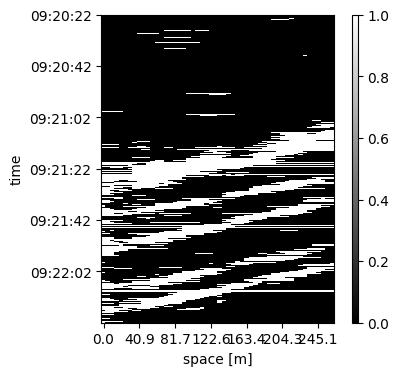

In [76]:
from skimage.filters import threshold_otsu

# Apply Otsu's thresholding
# thresh = threshold_otsu(df.values)
# binary_mask = df.values > thresh


binary_mask = data > np.percentile(data, 80)

# Visualize the binary mask
fig = plt.figure(figsize=(3, 4))
ax = plt.axes()

im = ax.imshow(binary_mask, interpolation='none', aspect='auto', cmap='gray')
plt.ylabel('time')
plt.xlabel('space [m]')

# Add colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)

x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)

plt.show()


In [77]:
binary_mask[binary_mask.nonzero()] = 1 
binary_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

## Connecting fragments using Morphological operations
Small gaps in objects can be connected using morphological operations like dilation and closing. This is especially useful after thresholding to fix fragmented objects.

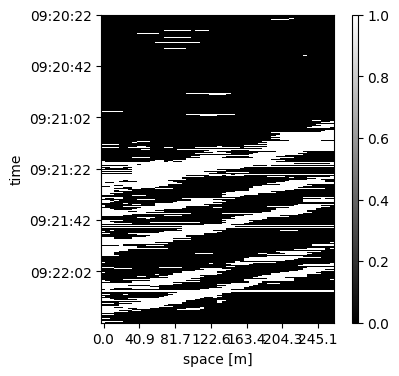

In [78]:
from skimage.morphology import binary_dilation, binary_erosion, binary_opening, binary_closing, disk

# Define a structuring element
kernel = np.array([
    [0,0,1],
    [0,1,0],
    [1,0,0]], np.uint8) # You can adjust the size of the structuring element as needed

# Apply morphological operations
# binary_dilated = binary_dilation(binary_mask, kernel)

closing = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=1)

# binary_eroded = binary_erosion(binary_mask, kernel)
# binary_opened = binary_opening(binary_mask, kernel, iterations=2)
# binary_closed = binary_closing(binary_opened, kernel)
# dilated2 = binary_dilation(binary_closed, kernel)

# Visualize the result after morphological operations
fig = plt.figure(figsize=(3, 4))
ax = plt.axes()

im = ax.imshow(closing, interpolation='none', aspect='auto', cmap='gray')
plt.ylabel('time')
plt.xlabel('space [m]')

# Add colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)

x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)

plt.show()

## Object Detection (Labeling)
Label connected regions in the binary mask to detect individual objects (slanted lines).

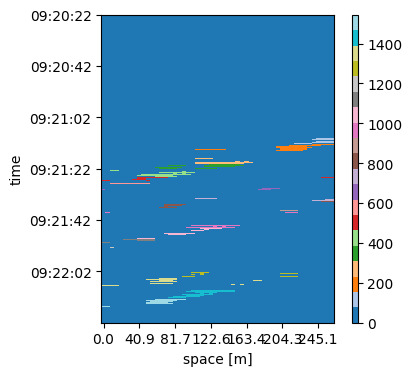

In [79]:
from skimage.measure import label, regionprops

# Label connected regions in the binary mask
labels = label(binary_closed)

# Extract region properties for detected objects
regions = regionprops(labels)

# Visualize labeled regions
fig = plt.figure(figsize=(3, 4))
ax = plt.axes()

im = ax.imshow(labels, interpolation='none', aspect='auto', cmap='tab20')
plt.ylabel('time')
plt.xlabel('space [m]')

cax = fig.add_axes([ax.get_position().x1 + 0.06, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(im, cax=cax)

x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels, 1))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)

plt.show()


## Calculate Velocities
For each detected object (region), calculate velocity based on the slope of the slanted line.

Extract Bounding Boxes or Orientation: Use regionprops to get the bounding box or orientation of each object.

Calculate Velocity: Velocity is determined as:

v = \frac{\Delta x}{\Delta t} = \frac{\text{dx} \cdot (\text{end_col} - \text{start_col})}{\text{dt} \cdot (\text{end_row} - \text{start_row})}

In [80]:
dx = 5.106500953873407  # Spatial resolution (meters)
dt = 0.0016  # Temporal resolution (seconds)
min_size = 50  # Minimum region size (rows)

velocities = []
for region in regions:
    min_row, min_col, max_row, max_col = region.bbox
    delta_space = (max_col - min_col) * dx
    delta_time = (max_row - min_row) * dt

    # Compute velocity only for valid and sufficiently large regions
    if delta_time > 0 and (max_row - min_row) >= min_size:
        velocity = delta_space / delta_time
        velocities.append(velocity)
    else:
        velocities.append(0)  # Assign zero velocity for invalid cases

print("Corrected Object Velocities (m/s):", sorted(velocities))


Corrected Object Velocities (m/s): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

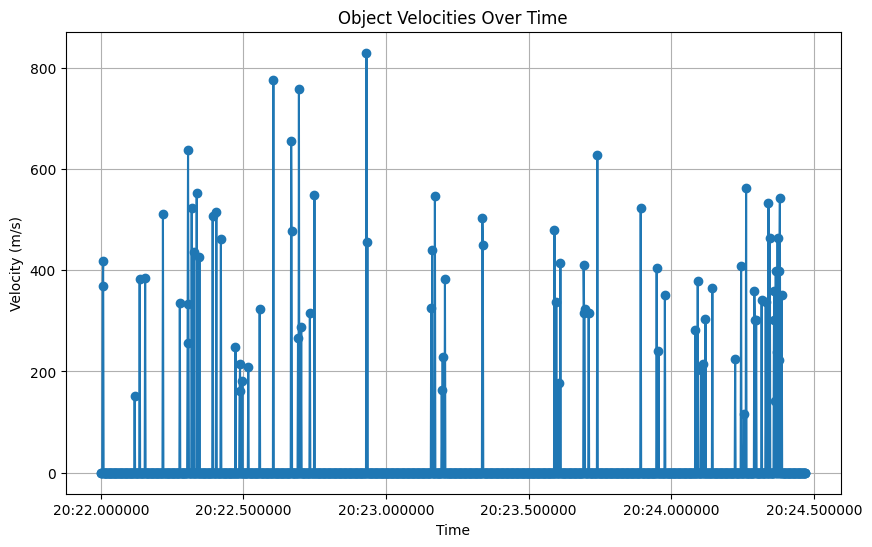

In [81]:
# Plot velocities
import matplotlib.pyplot as plt

time = df.index[:len(velocities)]  # Assuming velocities correspond to time slices
plt.figure(figsize=(10, 6))
plt.plot(time, velocities, marker='o')
plt.title("Object Velocities Over Time")
plt.xlabel("Time")
plt.ylabel("Velocity (m/s)")
plt.grid(True)
plt.show()
